In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = MNIST(root = 'data/' , download=True, transform = transforms.ToTensor())
test_dataset = MNIST(root = 'data/' , train = False, transform = transforms.ToTensor())

In [3]:
def show_image(index):
    image , label = dataset[index]
    plt.imshow(image.reshape(-1,28) , cmap='gray')
    print('Label : ', label)

Label :  2


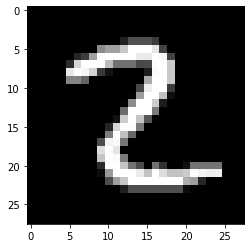

In [4]:
show_image(76)

In [5]:
train_ds , val_ds = random_split(dataset , [50000,10000])

In [6]:
batch_size = 64
train_loader = DataLoader(train_ds , batch_size , shuffle=True)
val_loader = DataLoader(val_ds , batch_size)

In [7]:
input_size = 28*28 #size of each image
output_classes = 10 # 10 different output classes

In [8]:
def curiosity(title = "Initial"):
    print(title)
    print("Model Weights")
    print(model.linear.weight)
    print("Model weights.grad")
    print(model.linear.weight.grad)
    print("Model Bias")
    print(model.linear.bias)
    print("Model bias.grad")
    print(model.linear.bias.grad)

def fit(model , lr , epochs , train_loader , val_loader, opt_fun=torch.optim.SGD):
    
    optimizer = opt_fun(model.parameters() , lr)
    history = []
    
    for i in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model , val_loader)
        model.epoch_end(i , result)
        history.append(result)
        
    return history

In [9]:
def accuracy(outputs , labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
def evaluate(model , val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [11]:
class MNISTModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size , output_classes)
        
    def forward(self,xb):
        xb = xb.reshape(-1,784)
        out = self.linear(xb)
        return out
    
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(
            batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [12]:
model = MNISTModel()

In [13]:
curiosity("Initial")

Initial
Model Weights
Parameter containing:
tensor([[ 0.0339,  0.0085,  0.0253,  ...,  0.0051, -0.0170,  0.0116],
        [ 0.0116,  0.0218, -0.0114,  ..., -0.0318, -0.0256, -0.0357],
        [-0.0324, -0.0302, -0.0312,  ...,  0.0158, -0.0224, -0.0003],
        ...,
        [-0.0160,  0.0136, -0.0098,  ...,  0.0120, -0.0190, -0.0161],
        [-0.0301, -0.0011,  0.0343,  ...,  0.0140,  0.0315,  0.0322],
        [-0.0013,  0.0046, -0.0206,  ...,  0.0300, -0.0051, -0.0158]],
       requires_grad=True)
Model weights.grad
None
Model Bias
Parameter containing:
tensor([-0.0333,  0.0088, -0.0188, -0.0101, -0.0331,  0.0086, -0.0089,  0.0060,
        -0.0017, -0.0014], requires_grad=True)
Model bias.grad
None


In [14]:
fit(model , 1e-4 , 10 , train_loader , val_loader)

Epoch [0], val_loss: 2.2665, val_acc: 0.1613
Epoch [1], val_loss: 2.1850, val_acc: 0.3215
Epoch [2], val_loss: 2.1094, val_acc: 0.4794
Epoch [3], val_loss: 2.0387, val_acc: 0.5768
Epoch [4], val_loss: 1.9724, val_acc: 0.6355
Epoch [5], val_loss: 1.9099, val_acc: 0.6714
Epoch [6], val_loss: 1.8510, val_acc: 0.6970
Epoch [7], val_loss: 1.7955, val_acc: 0.7144
Epoch [8], val_loss: 1.7432, val_acc: 0.7268
Epoch [9], val_loss: 1.6938, val_acc: 0.7359


[{'val_loss': 2.2665164470672607, 'val_acc': 0.1613256335258484},
 {'val_loss': 2.185014486312866, 'val_acc': 0.32145699858665466},
 {'val_loss': 2.109426498413086, 'val_acc': 0.4793988764286041},
 {'val_loss': 2.038749933242798, 'val_acc': 0.5768312215805054},
 {'val_loss': 1.9723724126815796, 'val_acc': 0.6355493664741516},
 {'val_loss': 1.909888744354248, 'val_acc': 0.6713773608207703},
 {'val_loss': 1.8510171175003052, 'val_acc': 0.696954607963562},
 {'val_loss': 1.795513391494751, 'val_acc': 0.7143710255622864},
 {'val_loss': 1.7431600093841553, 'val_acc': 0.7268112897872925},
 {'val_loss': 1.693786382675171, 'val_acc': 0.7358678579330444}]

In [15]:
fit(model , 1e-4 , 10 , train_loader , val_loader)

Epoch [0], val_loss: 1.6472, val_acc: 0.7451
Epoch [1], val_loss: 1.6032, val_acc: 0.7529
Epoch [2], val_loss: 1.5617, val_acc: 0.7596
Epoch [3], val_loss: 1.5226, val_acc: 0.7652
Epoch [4], val_loss: 1.4856, val_acc: 0.7700
Epoch [5], val_loss: 1.4506, val_acc: 0.7742
Epoch [6], val_loss: 1.4176, val_acc: 0.7787
Epoch [7], val_loss: 1.3863, val_acc: 0.7813
Epoch [8], val_loss: 1.3567, val_acc: 0.7845
Epoch [9], val_loss: 1.3286, val_acc: 0.7883


[{'val_loss': 1.6472069025039673, 'val_acc': 0.7451233863830566},
 {'val_loss': 1.6032404899597168, 'val_acc': 0.752886176109314},
 {'val_loss': 1.5617460012435913, 'val_acc': 0.7595541477203369},
 {'val_loss': 1.5225803852081299, 'val_acc': 0.7652269005775452},
 {'val_loss': 1.485579252243042, 'val_acc': 0.7700039744377136},
 {'val_loss': 1.4506185054779053, 'val_acc': 0.7741839289665222},
 {'val_loss': 1.4175645112991333, 'val_acc': 0.7786624431610107},
 {'val_loss': 1.3862861394882202, 'val_acc': 0.7813495397567749},
 {'val_loss': 1.3566724061965942, 'val_acc': 0.784534215927124},
 {'val_loss': 1.3286198377609253, 'val_acc': 0.7883160710334778}]

In [16]:
history1 = fit(model , 1e-4 , 10 , train_loader , val_loader)

Epoch [0], val_loss: 1.3020, val_acc: 0.7912
Epoch [1], val_loss: 1.2768, val_acc: 0.7931
Epoch [2], val_loss: 1.2528, val_acc: 0.7952
Epoch [3], val_loss: 1.2300, val_acc: 0.7978
Epoch [4], val_loss: 1.2083, val_acc: 0.8000
Epoch [5], val_loss: 1.1877, val_acc: 0.8024
Epoch [6], val_loss: 1.1680, val_acc: 0.8042
Epoch [7], val_loss: 1.1492, val_acc: 0.8060
Epoch [8], val_loss: 1.1313, val_acc: 0.8079
Epoch [9], val_loss: 1.1142, val_acc: 0.8100


In [17]:
def predict_image(img, model):
    print(img.shape)
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [18]:
predict_image(test_dataset[56][0] , model)

torch.Size([1, 28, 28])


4